<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/5_4_1_RNN_Model_Design(Char_RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

# RNN Model Design (Char-RNN)

## **Import Module**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [5, 3.5]

device = 'cuda:0'
torch.__version__, pl.__version__

('2.0.1+cu118', '2.0.3')

## **DataSet**

### 학습할 문장 만들기

In [ ]:
# 학습할 문장
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")
print ("FOLLOWING IS OUR TRAINING SEQUENCE:")
print (sentence)
print ("Length of 'test sentence' is %s" %len(sentence))

FOLLOWING IS OUR TRAINING SEQUENCE:
if you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.
Length of 'test sentence' is 180


### 입력 문자열과 타겟 문자 준비

In [ ]:
# make charater dictionary
char_set = list(set(sentence)) # char set 생성
char_dic = {w: i for i, w in enumerate(char_set)}
print ("CHARACTERS: ")
print (len(char_set))
print (char_set)
print ("DICTIONARY: ")
print (len(char_dic))
print (char_dic)

CHARACTERS: 
25
['c', 'r', "'", 'k', 'i', ' ', 'g', 't', 'n', 'p', 'b', 'm', 'o', '.', 'w', 'u', 's', 'd', 'h', 'f', ',', 'e', 'y', 'a', 'l']
DICTIONARY: 
25
{'c': 0, 'r': 1, "'": 2, 'k': 3, 'i': 4, ' ': 5, 'g': 6, 't': 7, 'n': 8, 'p': 9, 'b': 10, 'm': 11, 'o': 12, '.': 13, 'w': 14, 'u': 15, 's': 16, 'd': 17, 'h': 18, 'f': 19, ',': 20, 'e': 21, 'y': 22, 'a': 23, 'l': 24}


In [ ]:
data_dim    = len(char_set) # train data X:input
num_classes = len(char_set) # trian data Y:target
sequence_length = 10        # any arbitrary number
features = 1                # X,Y index
print ('data_dim : %d' %data_dim)
print ('num_classes : %d' %num_classes)

data_dim : 25
num_classes : 25


In [ ]:
dataX = []  # input sequence list
dataY = []  # target sequence list

# we will make 170 sequences
for i in range(0, len(sentence) - sequence_length):
    # 10 characters = 1 training sequence
    x_str = sentence[i : i+sequence_length]
    y_str = sentence[i+1 : i+sequence_length+1]
    # convert x, y str to index(int)
    x_idx = [char_dic[c] for c in x_str]
    y_idx = [char_dic[c] for c in y_str]
    # append to dataset list
    dataX.append(x_idx)
    dataY.append(y_idx)

    # monitoring
    if i<5:
        print ("[%3d/%3d] [%s]=>[%s]" % (i, len(sentence), x_str, y_str))
        print ("%s%s=>%s" % (' '*10, x_idx, y_idx))

[  0/180] [if you wan]=>[f you want]
          [4, 19, 5, 22, 12, 15, 5, 14, 23, 8]=>[19, 5, 22, 12, 15, 5, 14, 23, 8, 7]
[  1/180] [f you want]=>[ you want ]
          [19, 5, 22, 12, 15, 5, 14, 23, 8, 7]=>[5, 22, 12, 15, 5, 14, 23, 8, 7, 5]
[  2/180] [ you want ]=>[you want t]
          [5, 22, 12, 15, 5, 14, 23, 8, 7, 5]=>[22, 12, 15, 5, 14, 23, 8, 7, 5, 7]
[  3/180] [you want t]=>[ou want to]
          [22, 12, 15, 5, 14, 23, 8, 7, 5, 7]=>[12, 15, 5, 14, 23, 8, 7, 5, 7, 12]
[  4/180] [ou want to]=>[u want to ]
          [12, 15, 5, 14, 23, 8, 7, 5, 7, 12]=>[15, 5, 14, 23, 8, 7, 5, 7, 12, 5]


**입력문자 index의 list를 ndarrary로 변환**

In [ ]:
X = np.array(dataX)   # ndarray(170,10)<-[170,10]
X = np.reshape(X,(X.shape[0],X.shape[1],features))
ps(X,'X') # (170,10,1)

# Target tensor 생성 # ndarray(170,10,1)<-[170,10]
Y = np.array(dataY)   # (170,10)<-[170,10]
Y = Y= np.reshape(Y,(Y.shape[0],Y.shape[1],features))
ps(Y,'Y') # (170,10,1)

Y1 = np.array(dataY)[:,-1]  # 마지막 문자만, (170,)<-[170,10]
Y1= np.reshape(Y1,(Y1.shape[0],features)) # (170,1)
ps(Y1,'Y1') # (170,1)

[X] Shape(170, 10, 1)
[Y] Shape(170, 10, 1)
[Y1] Shape(170, 1)


#### 참고자료
**** Shape 살펴보기 ****
- shape은 np.array(ndarray)가 갖은 n-dim 행렬의 shape을 보이는 것

In [ ]:
list_ = [1,2,3,4,5]
print(list_)
list_

* 행렬: [ 1 2 3 ]
* 벡터: (1,2,3)
* list:[1,2,3]
* ndarray : arrary(list) (= n-dim 행렬)

In [ ]:
na = np.array([1,2,3,4,5])
print(na)                   # value를 print
na                          # 무엇인지 보여줌(contents)

[1 2 3 4 5]


array([1, 2, 3, 4, 5])

In [ ]:
list_ = [1,2,3,4,5]
# list는 shape을 표현할 수 없음(행렬이 아님)
p(list_)                   # [1,2,3,4,5]         shape(x)
na = np.array(list_)
p(na)                      # [1 2 3 4 5]         (5,)
p(np.reshape(na,(5,1)))    # [[1][2][3][4][5]]   (5,1)
p(np.reshape(na,(1,5)))    # [[1 2 3 4 5]]       (1,5)
p(np.reshape(na,(1,5,1)))  # [[[1][2][3][4][5]]] (1,5,1)
p(np.reshape(na,(1,5,1,1)))# [[[[1]][[2]][[3]][[4]][[5]]]]
p(np.reshape(na,(1,1,5,1)))# [[[[1][2][3][4][5]]]]
p(np.squeeze(np.reshape(na,(1,5,1))))# [1 2 3 4 5] (5,)

### Define CustormDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return torch.Tensor(self.x[idx]), torch.LongTensor(self.y[idx]).to(device)

trainDataset = CustomDataset(X, Y1)
trainDataLoader = DataLoader(trainDataset, shuffle=True,
                             drop_last=False, batch_size=2)

trainDataset_many = CustomDataset(X, Y)
trainDataLoader_many = DataLoader(trainDataset_many, shuffle=True,
                                  drop_last=False, batch_size=1)

## **Model-1** : many to one model

### Define

**주의 사항**
* model에 softmax가 없는 이유는 torch의 cross_entropy 함수에서 자체적으로 softmax를 한 후 loss를 계산하기 때문이다.

In [ ]:
hidden_dim = 75 #150
class ManyToOneLSTM(pl.LightningModule):
    def __init__(self, features, units, num_classes, batch_first=True):
        super(ManyToOneLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=features, hidden_size=units,
                            batch_first=batch_first)
        self.linear = nn.Linear(units, num_classes)
    def forward(self, x):
        out, (hn, cn) = self.lstm(x) #(bs,timesteps,units)
        out = self.linear(out[:, -1, :]) #(bs,1)<-(bs,units)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)       #(bs, num_classes)
        y = y.squeeze(dim=-1) #(bs,)<-(bs,1)
        loss = F.cross_entropy(y_hat, y)
        acc = FM.accuracy(y_hat, y, task='multiclass', num_classes=25 )
        metrics = {'loss':loss, 'acc':acc}
        self.log_dict(metrics,on_step=False,on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = ManyToOneLSTM(features, hidden_dim, num_classes)

inputs = torch.zeros(2,sequence_length,features)
output = model(inputs) #(2,25)
ps(output)
summary(model, input_size=(2, sequence_length, features)) #(4,10,1)

[] Shapetorch.Size([2, 25])


Layer (type:depth-idx)                   Output Shape              Param #
ManyToOneLSTM                            [2, 25]                   --
├─LSTM: 1-1                              [2, 10, 75]               23,400
├─Linear: 1-2                            [2, 25]                   1,900
Total params: 25,300
Trainable params: 25,300
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.10
Estimated Total Size (MB): 0.11

In [ ]:
#torch.onnx.export(model.cpu(), inputs, 'CharRNN-1.onnx')

### Fit

In [ ]:
%%time
trainer = Trainer(max_epochs=200, accelerator='auto')
trainer.fit(model, trainDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 23.4 K
1 | linear | Linear | 1.9 K 
----------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


CPU times: user 1min 7s, sys: 1.49 s, total: 1min 8s
Wall time: 1min 8s


In [ ]:
log = {}
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'lightning_logs/version_{v_num}'

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

In [ ]:
#pd.DataFrame(event_accumulator.Scalars("epoch"))

In [ ]:
#pd.DataFrame(event_accumulator.Scalars("acc"))

In [ ]:
#pd.DataFrame(event_accumulator.Scalars("loss"))

In [ ]:
loss = [x.value for x in event_accumulator.Scalars('loss')]
acc = [x.value for x in event_accumulator.Scalars('acc')]
print(f'Max Acc:{max(acc)}')
print(f'Min Loss:{max(loss)}')

log['ManyToOneLSTM'] = [loss, acc]

plt.plot(log['ManyToOneLSTM'][0], linestyle='--', label="train_loss")
plt.plot(log['ManyToOneLSTM'][1], linestyle='--', label="train_acc")

#plt.ylim(0.1, 1)
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

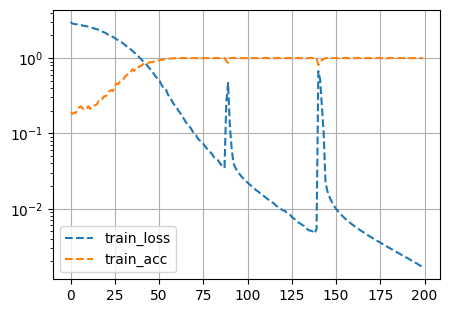

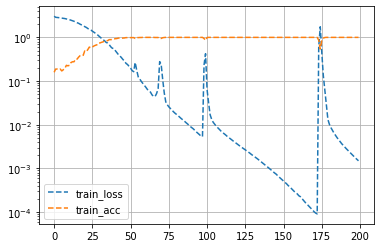 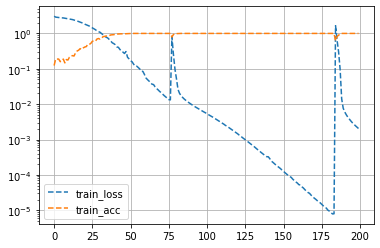

### **Generate Text:** analysis

#### Define generate_seq function

In [ ]:
# 문자열 생성하기
def generate_seq(model, char_dic, seq_length, seed_text, n_chars):
    in_text = seed_text    # seed 문자열 + 생성 문자
    # 생성할 문자열의 수 = n_chars
    for i in range(n_chars):
        # 문자 encode : 문자 -> int
        encoded = [char_dic[char] for char in in_text]
        # 뒷부분 10자만 사용
        encoded = encoded[-sequence_length:]
        encoded = np.array(encoded)
        # Tensor(1,10,1) <- np(1,10)
        encoded = torch.FloatTensor(np.reshape(encoded,(1,seq_length,1)))
        # 다음문자 추론
        model.eval()
        yhat = model(encoded)  # yhat.shape=(1,25): class 확률
        yhat = np.argmax(yhat.detach().numpy(), axis=1) # index <- pb.
        # 문자 디코딩 : integer -> character
        for char, index in char_dic.items():
            if index == yhat:
                break
        in_text += char    # 문자열에 추가
    return in_text

#### Generate a sequence of characters

학습문장: if you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endseed_textnsity of the sea.

In [ ]:
# test start of rhyme
print('Trigger characters: "want to bu "\nResult: \n"{}"'.format(
      generate_seq(model, char_dic, sequence_length, 'want to bu', 200)))
# test mid-line
print('\nTrigger characters: "collect wo"\nResult: \n"{}"'.format(
      generate_seq(model, char_dic, sequence_length, 'collect wo', 200)))
# test not in original
print('\nTrigger characters: "abbcr than"\nResult: "{}"'.format(
      generate_seq(model, char_dic, sequence_length, 'abbcr than', 200)))

Trigger characters: "want to bu "
Result: 
"want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.s immensity of the sea.s immensity of"

Trigger characters: "collect wo"
Result: 
"collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea."

Trigger characters: "abbcr than"
Result: "abbcr thanitaacs and work, but rather teach them to long for the endless immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea.s"


- **epoch 200**

Trigger characters: "want to bu "
Result:
"want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. eon wood and don't assign them tasks"

Trigger characters: "collect wo"
Result:
"collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. eon wood and don't assign them tasks and work, but rather teach them to long for the endles"

Trigger characters: "abbcr than"
Result: "abbcr thanhimttaagh them to long for the endless immensity of the sea. eon wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea. eon wood and don't assig"

=====


- **epoch 50**

Trigger characters: "want to bu "
Result:  "want to build a ship, don't dr't assign them tosss and work, but r ather  teoohimm for the tearp,
ton ther te chlthem tosss and work, but rather
teoohimm   for the tearp, ton ther te chlthem tosss and work, but rat"

Trigger characters: "collect wo"
Result:
"collect wood and dossig butpo pe to build a ship, don't dr't assign them
tosss and work, but rather
teoohimm for the tearp, ton ther te chlthem tosss and work, but rather teoohimm for the tearp, ton ther te chl"

Trigger characters: "aabbcr than"
Result: "abbcr than'thossign them tosss and work, but rather teoohimm for the
 tearp, ton ther te chlthem
 tosss and work, but rather teoohimm for the tearp, ton ther te chlthem tosss and work, but rather teoohimm for the"


## **Model-2** : many to many model

### Define

In [ ]:
hidden_dim = 75 #150
class ManyToManyLSTM(pl.LightningModule):
    def __init__(self, features, units, num_classes, batch_first=True):
        super(ManyToManyLSTM, self).__init__()
        self.lstm = nn.LSTM(features, units, batch_first=batch_first)
        self.linear = nn.Linear(units, num_classes) #(bs,10,25)
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.linear(out)
        return out #(bs,10,25)

    def training_step(self, batch, batch_idx):
        x, y = batch    # y:(bs,10,1)
        y_hat = self(x) # (bs,10,25)
        y = y.squeeze(dim=-1) #(bs,10)
        loss = acc = 0.0
        for i in range(x.shape[1]): # seq.에 대한 평균 구하기
            loss += F.cross_entropy(y_hat[:, i, :], y[:, i])
            acc += FM.accuracy(y_hat[:, i, :], y[:, i],task='multiclass', num_classes=25 )

        loss /= sequence_length
        acc /= sequence_length
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,on_step=False,on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = ManyToManyLSTM(features, hidden_dim, num_classes)
summary(model, input_size=(2, sequence_length, features))

Layer (type:depth-idx)                   Output Shape              Param #
ManyToManyLSTM                           [2, 10, 25]               --
├─LSTM: 1-1                              [2, 10, 75]               23,400
├─Linear: 1-2                            [2, 10, 25]               1,900
Total params: 25,300
Trainable params: 25,300
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.10
Estimated Total Size (MB): 0.12

### Fit

In [ ]:
%%time
trainer = Trainer(max_epochs=200, accelerator='auto')
trainer.fit(model, trainDataLoader_many)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 23.4 K
1 | linear | Linear | 1.9 K 
----------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


CPU times: user 5min 44s, sys: 2.88 s, total: 5min 46s
Wall time: 5min 47s


Wall time: 5min 47s

In [ ]:
log = {}
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'lightning_logs/version_{v_num}'

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

In [ ]:
loss = [x.value for x in event_accumulator.Scalars('loss')]
acc = [x.value for x in event_accumulator.Scalars('acc')]
print(f'Max Acc:{max(acc)}')
print(f'Min Loss:{max(loss)}')

log['ManyToManyLSTM'] = [loss, acc]

plt.plot(log['ManyToManyLSTM'][0], linestyle='--', label="train_loss")
plt.plot(log['ManyToManyLSTM'][1], linestyle='--', label="train_acc")

plt.ylim(0.1, 1.)
#plt.semilogy()
plt.legend()
plt.grid()
plt.show()

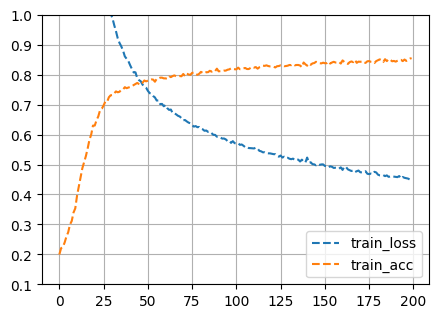

### **Generate Text:** analysis

##### Define generate_seq function

- 10개의 출력 시퀀스를 받으므로 수정 필요

In [ ]:
# 문자열 생성하기
def generate_seq2(model, char_dic, seq_length, seed_text, n_chars):
    in_text = seed_text									# seed 문자열 + 생성 문자
    # 생성할 문자열의 수 = n_chars
    for i in range(n_chars):
        # 문자 encode : 문자 -> int
        encoded = [char_dic[char] for char in in_text]
        # 문자열 크기 조정 : max보다 크면 앞부분 제거
        encoded = encoded[-sequence_length:]
        encoded = np.array(encoded)
        # Tensor(1,10,1) <- np(1,10)
        encoded = torch.FloatTensor(np.reshape(encoded,(1,seq_length,1)))
        # 다음문자 추론
        yhat = model(torch.FloatTensor(encoded))  ## yhat.shape=(1,10,25):확률 시퀀스
        yhat = np.argmax(yhat.cpu().detach().numpy(), axis=2) # 확률 중에서 가장 큰 값의 위치 (1,10,1)<(1,10,25)
        yhat = np.squeeze(yhat)        # (10,) <- (1,10,1)
        # 문자 디코딩 : integer -> character
        for char, index in char_dic.items():
            if index == yhat[9]:         # 시퀀스에서 마지막 값을 사용
                break
        in_text += char    # 문자열에 추가
    return in_text

##### Generate a sequence of characters

학습문장: if you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.

In [ ]:
# test start of rhyme
print('Trigger characters: "want to bu "\nResult: \n"{}"'.format(
      generate_seq2(model, char_dic, sequence_length, 'want to bu', 200)))
# test mid-line
print('\nTrigger characters: "collect wo"\nResult: \n"{}"'.format(
      generate_seq2(model, char_dic, sequence_length, 'collect wo', 200)))
# test not in original
print('\nTrigger characters: "aabbcr than"\nResult: "{}"'.format(
      generate_seq2(model, char_dic, sequence_length, 'abbcr than', 200)))

Trigger characters: "want to bu "
Result: 
"want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.s immensity of the sea.s immensity of"

Trigger characters: "collect wo"
Result: 
"collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea."

Trigger characters: "aabbcr than"
Result: "abbcr thaneituem tasks and work, but rather teach them to long for the endless immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the sea.s immensity of the"


Trigger characters: "want to bu "
Result:
"want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.ddon't assign them tasks and work, bu"

Trigger characters: "collect wo"
Result:
"collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.ddon't assign them tasks and work, but rather teach them to long for the endless immensity o"

Trigger characters: "aabbcr than"
Result: "abbcr than tasks and work, but rather teach them to long for the endless immensity of the sea.ddon't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.ddon't assign "

- **epoch 200**

Trigger characters: "want to bu "
Result:
"want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.ddon't assign them tasks and work, bu"

Trigger characters: "collect wo"
Result:
"collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.ddon't assign them tasks and work, but rather teach them to long for the endless immensity o"

Trigger characters: "aabbcr than"
Result: "abbcr than tasks and work, but rather teach them to long for the endless immensity of the sea.ddon't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.ddon't assign "
